In [432]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [462]:
r, g, b = sns.color_palette('deep')[3]
print(r * 255, g * 255, b * 255)

196.0 78.0 82.0


In [301]:
# notes:
# https://matplotlib.org/stable/users/explain/customizing.html

In [302]:
con = duckdb.connect()

con.execute("""
CREATE MACRO pretty_system(s) AS
CASE s
WHEN 'databend' THEN 'Databend'
WHEN 'duckdb' THEN 'DuckDB'
WHEN 'clickhouse' THEN 'ClickHouse'
WHEN 'hyper' THEN 'HyPer'
WHEN 'umbra' THEN 'Umbra'
ELSE s END
""")

def incr():
    global n
    n = n + 1
    return n - 1

n = 1
# WHEN 'l_suppkey' THEN {incr()}
# WHEN 'l_suppkey-l_returnflag-l_linestatus' THEN {incr()}
# WHEN 'l_shipmode' THEN {incr()}
q = f"""
CREATE MACRO grouping_num(grouping) AS
CASE grouping
WHEN 'l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_partkey' THEN {incr()}
WHEN 'l_partkey-l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_suppkey-l_partkey' THEN {incr()}
WHEN 'l_orderkey' THEN {incr()}
WHEN 'l_orderkey-l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_returnflag-l_linestatus' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_shipinstruct' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_shipmode' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_shipinstruct-l_shipmode' THEN {incr()}
WHEN 'l_orderkey-l_partkey' THEN {incr()}
WHEN 'l_orderkey-l_suppkey' THEN {incr()}
WHEN 'l_suppkey-l_partkey-l_orderkey' THEN {incr()}
ELSE -1 END
"""
# print(q)
con.execute(q)

n = 1
# WHEN {incr()} THEN 'l_suppkey' 
# WHEN {incr()} THEN 'l_suppkey-l_returnflag-l_linestatus' 
# WHEN {incr()} THEN 'l_shipmode'
q = f"""
CREATE MACRO num_grouping(num) AS
CASE num
WHEN {incr()} THEN 'l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_partkey' 
WHEN {incr()} THEN 'l_partkey-l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_suppkey-l_partkey' 
WHEN {incr()} THEN 'l_orderkey' 
WHEN {incr()} THEN 'l_orderkey-l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_returnflag-l_linestatus' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_shipinstruct' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_shipmode' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_shipinstruct-l_shipmode' 
WHEN {incr()} THEN 'l_orderkey-l_partkey' 
WHEN {incr()} THEN 'l_orderkey-l_suppkey' 
WHEN {incr()} THEN 'l_suppkey-l_partkey-l_orderkey' 
ELSE '?' END
"""
# print(q)
con.execute(q)
systems = sorted(['duckdb', 'hyper', 'clickhouse', 'umbra']) # , 'databend'
for system in systems: # TODO: ATTACH IF NOT EXISTS has not been merged yet
    con.execute(f"""ATTACH '../results/{system}.db' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE VIEW IF NOT EXISTS all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_int_df = con.execute("""
SELECT * REPLACE (median(runtime) AS runtime)
FROM all_results
WHERE sf <= 128
AND grouping NOT IN ('l_suppkey', 'l_suppkey-l_returnflag-l_linestatus', 'l_shipmode', 'all')
GROUP BY ALL""").fetchdf()
results_df = con.execute("""SELECT * REPLACE(sf::VARCHAR as sf) FROM results_int_df ORDER BY system, sf::INT""").fetchdf()
results_df.head()

,system,sf,grouping,wide,runtime
0,clickhouse,1,l_suppkey-l_partkey-l_orderkey,True,0.429946
1,clickhouse,1,l_orderkey-l_returnflag-l_linestatus,True,0.340879
2,clickhouse,1,l_partkey,True,0.157625
3,clickhouse,1,l_partkey-l_returnflag-l_linestatus,False,0.145635
4,clickhouse,1,l_suppkey-l_partkey-l_shipmode,False,0.183470


In [303]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.9',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [304]:
def plot_simple(num, wide):
    f = plt.figure(figsize=(6, 3))
    modified_style = copy.copy(my_style)
    # modified_style['xtick.major.bottom'] = False
    # modified_style['ytick.major.left'] = False
    grouping = con.execute(f"""SELECT num_grouping({num})""").fetchall()[0][0]
    
    p = (
        so.Plot(
            con.execute(f"""
                SELECT pretty_system(system) as System,
                sf AS "Scale Factor", grouping, wide, runtime AS "Execution Time [s]"
                FROM results_df
                WHERE grouping = '{grouping}'
                AND wide = {wide}
            """).fetchdf(),
            x='Scale Factor', y='Execution Time [s]', color='System'
        )
        .facet(col='System')
        .add(so.Line(linewidth=3, marker='o', edgecolor='w'))
        .share(x='col', y='row')
        .theme(modified_style)
        .on(f)
        .plot()
    )
    
    legend = f.legends.pop(0)
    # f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
    f.tight_layout()

    f.savefig(f"../figures/{'wide' if wide else 'thin'}_{num}.eps", bbox_inches='tight')
    plt.close(f)

In [305]:
# for wide in [False, True]:
#     for num in range(1, 17):
#         plot_simple(num, wide)

In [359]:
@FuncFormatter
def my_formatter(x, pos):
    if x >= 1:
        return "{:.0f}".format(x)
    return "{:.1g}".format(x)

/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1971346642.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[8].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1971346642.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[9].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1971346642.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[10].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1971346642.py:79: UserWarning: set_ticklabels() shou

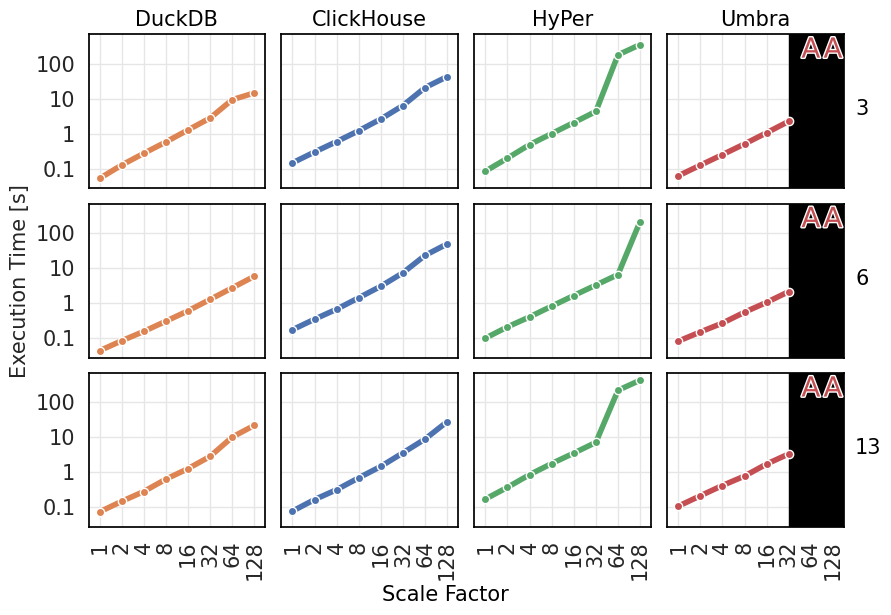

In [466]:
nums = [3, 6, 13]
groups = []
for num in nums:
    groups.append(f"""'{con.execute(f"SELECT num_grouping({num})").fetchall()[0][0]}'""")

f = plt.figure(figsize=(9, 6))
modified_style = copy.copy(my_style)
modified_style['xtick.major.bottom'] = True
modified_style['axes.labelsize'] = 15
modified_style['ytick.labelsize'] = 15
# modified_style['ytick.major.left'] = False

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) as System,
            sf AS "Scale Factor", grouping_num(grouping) as Grouping, wide, runtime AS "Execution Time [s]"
            FROM results_df
            WHERE grouping IN ({', '.join(groups)})
            AND wide = False
            AND runtime > 0
        """).fetchdf(),
        x='Scale Factor', y='Execution Time [s]', color='System'
    )
    .scale(y=so.Continuous(trans='log10').label(my_formatter).tick(minor=0))
    .facet(col='System', row='Grouping', order={"col": ["DuckDB", "ClickHouse", "HyPer", "Umbra"]})
    .add(so.Line(linewidth=4, marker='o', edgecolor='w'))
    .theme(modified_style)
    .on(f)
    .plot()
)

fsize = 20

txt = f.axes[3].text(6, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[3].text(7, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[7].text(6, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[7].text(7, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[11].text(6, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[11].text(7, 250, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

rect = patches.Rectangle((5, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[3].add_patch(rect)
rect = patches.Rectangle((5, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[7].add_patch(rect)
rect = patches.Rectangle((5, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[11].add_patch(rect)

f.axes[0].set_title('DuckDB', fontsize=15)
f.axes[1].set_title('ClickHouse', fontsize=15)
f.axes[2].set_title('HyPer', fontsize=15)
f.axes[3].set_title('Umbra', fontsize=15)
for i in range(4, 12):
    f.axes[i].set_title('')

f.axes[3].text(8, 5, "3", horizontalalignment='left', verticalalignment='center', fontsize=15)
f.axes[7].text(8, 5, "6", horizontalalignment='left', verticalalignment='center', fontsize=15)
f.axes[11].text(8, 5, "13", horizontalalignment='left', verticalalignment='center', fontsize=15)

for i in range(12):
    f.axes[i].grid(True, 'both')

f.axes[0].set_ylabel('')
f.axes[8].set_ylabel('')

f.axes[8].set_xlabel('')
f.axes[9].set_xlabel('')
f.axes[10].set_xlabel('')
f.axes[11].set_xlabel('')
f.axes[8].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.axes[9].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.axes[10].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.axes[11].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.text(0.5, 0, 'Scale Factor', horizontalalignment='center', verticalalignment='center', fontsize=15)

# for i in range(3):
#     temp = f.axes[3*i]
#     f.axes[3*i] = f.axes[3*i + 1]
#     f.axes[3*i + 1] = temp

legend = f.legends.pop(0)
# f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
f.tight_layout()

f.savefig(f"../figures/thins_cliff.eps", bbox_inches='tight')
# plt.close(f)

In [204]:
sns.color_palette('deep')

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/3551124823.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[8].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/3551124823.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[9].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/3551124823.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[10].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/3551124823.py:96: UserWarning: set_ticklabels() shou

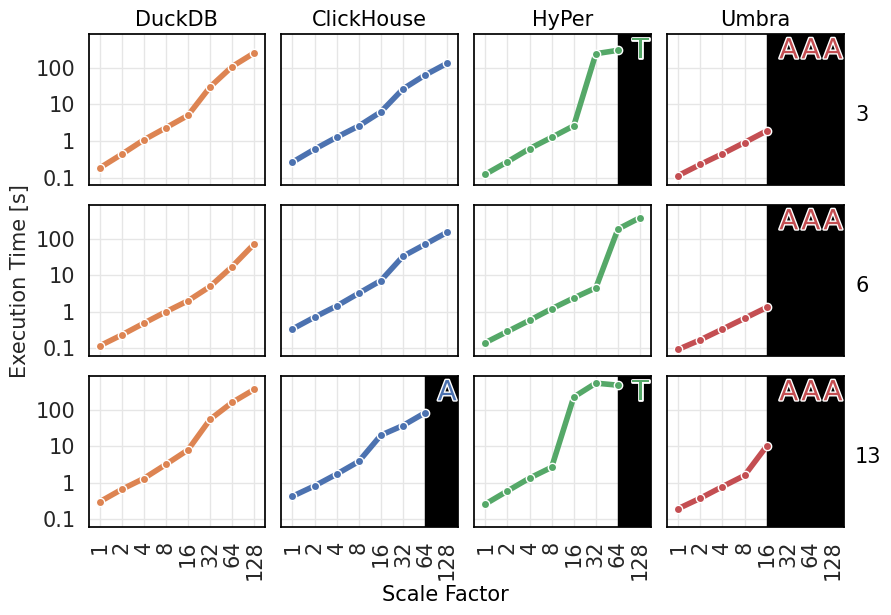

In [467]:
f = plt.figure(figsize=(9, 6))
modified_style = copy.copy(my_style)
modified_style['xtick.major.bottom'] = True
modified_style['axes.labelsize'] = 15
modified_style['ytick.labelsize'] = 15
# modified_style['ytick.major.left'] = False

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) as System,
            sf AS "Scale Factor", grouping_num(grouping) as Grouping, wide, runtime AS "Execution Time [s]"
            FROM results_df
            WHERE grouping IN ({', '.join(groups)})
            AND wide = True
            AND runtime > 0
        """).fetchdf(),
        x='Scale Factor', y='Execution Time [s]', color='System'
    )
    .scale(y=so.Continuous(trans='log10').label(my_formatter).tick(minor=0))
    .facet(col='System', row='Grouping', order={"col": ["DuckDB", "ClickHouse", "HyPer", "Umbra"]})
    .add(so.Line(linewidth=4, marker='o', edgecolor='w'))
    .theme(modified_style)
    .on(f)
    .plot()
)

fsize = 20

txt = f.axes[9].text(7, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[0], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

rect = patches.Rectangle((6, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[9].add_patch(rect)

txt = f.axes[2].text(7, 300, "T", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[2], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[10].text(7, 300, "T", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[2], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

rect = patches.Rectangle((6, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[2].add_patch(rect)
rect = patches.Rectangle((6, 0.000001), 2.5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[10].add_patch(rect)

txt = f.axes[3].text(5, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[3].text(6, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[3].text(7, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[7].text(5, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[7].text(6, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[7].text(7, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[11].text(5, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[11].text(6, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[11].text(7, 300, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

rect = patches.Rectangle((4, 0.000001), 5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[3].add_patch(rect)
rect = patches.Rectangle((4, 0.000001), 5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[7].add_patch(rect)
rect = patches.Rectangle((4, 0.000001), 5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[11].add_patch(rect)

f.axes[0].set_title('DuckDB', fontsize=15)
f.axes[1].set_title('ClickHouse', fontsize=15)
f.axes[2].set_title('HyPer', fontsize=15)
f.axes[3].set_title('Umbra', fontsize=15)
for i in range(4, 12):
    f.axes[i].set_title('')

f.axes[3].text(8, 5, "3", horizontalalignment='left', verticalalignment='center', fontsize=15)
f.axes[7].text(8, 5, "6", horizontalalignment='left', verticalalignment='center', fontsize=15)
f.axes[11].text(8, 5, "13", horizontalalignment='left', verticalalignment='center', fontsize=15)

for i in range(12):
    f.axes[i].grid(True, 'both')

f.axes[0].set_ylabel('')
f.axes[8].set_ylabel('')

f.axes[8].set_xlabel('')
f.axes[9].set_xlabel('')
f.axes[10].set_xlabel('')
f.axes[11].set_xlabel('')
f.axes[8].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.axes[9].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.axes[10].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.axes[11].set_xticklabels(f.axes[8].get_xticklabels(), rotation=90, fontsize=15)
f.text(0.5, 0, 'Scale Factor', horizontalalignment='center', verticalalignment='center', fontsize=15)

legend = f.legends.pop(0)
# f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
f.tight_layout()

f.savefig(f"../figures/wides_cliff.eps", bbox_inches='tight')
# plt.close(f)

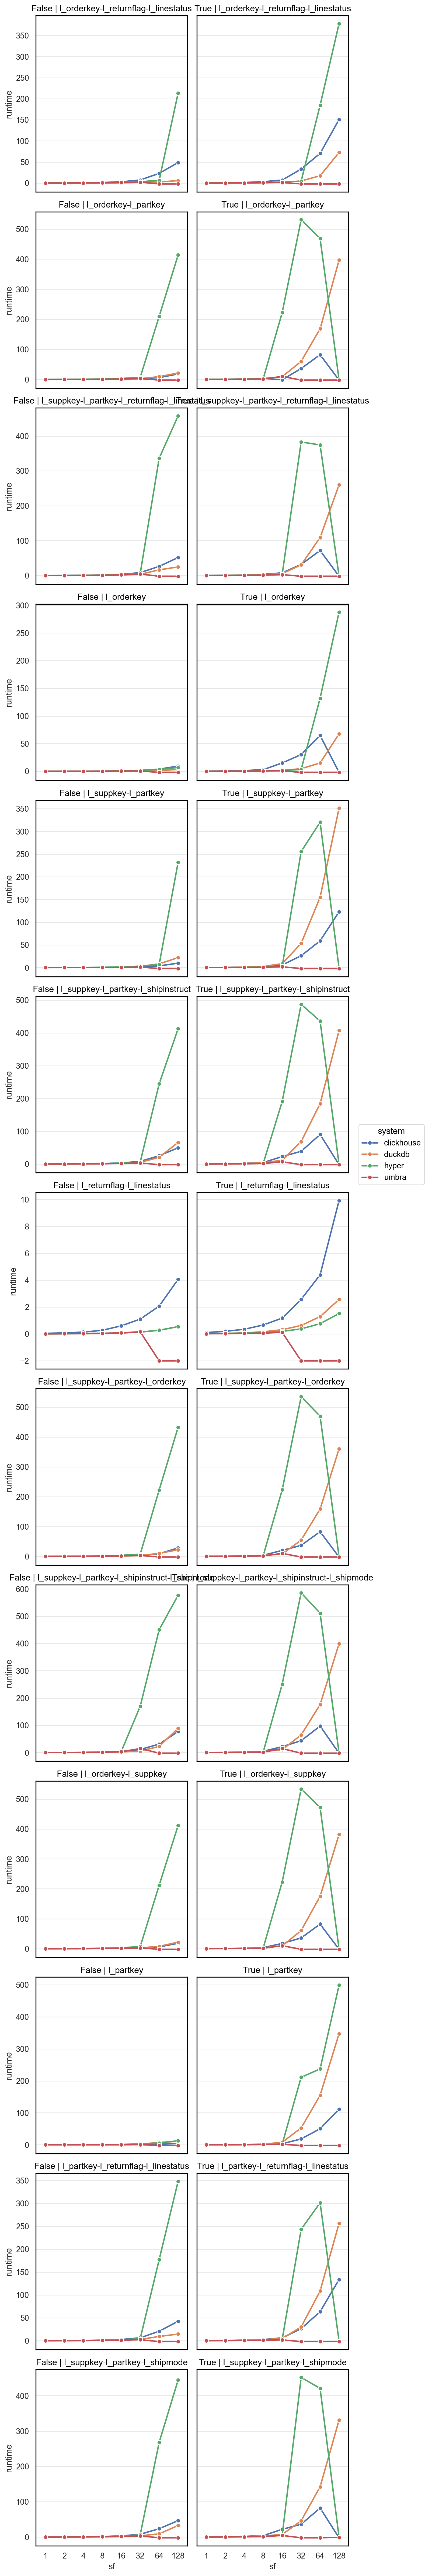

In [272]:
p = (
    so.Plot(results_df, x='sf', y='runtime', color='system')
    .facet(col='wide', row='grouping')
    .add(so.Line(linewidth=2, marker='o', edgecolor='w'))
    .share(x='col', y='row')
    .layout(size=(7, 50), engine='tight')
    .theme(my_style)
)
p

In [420]:
def compare(k):
    sf = k[1]
    sys = k[2]

    base = sf * 1000
    if sys == 'Cl':
        base += 1
    elif sys == 'Hy':
        base += 2
    elif sys == 'Um':
        base += 3
    return base

In [426]:
    # --CASE WHEN runtime < 10 THEN format('{:.2f}', runtime)
    # --WHEN runtime < 100 THEN format('{:.1f}', runtime)
    # --WHEN runtime < 1000 THEN format('{:.0f}', runtime)
    # --ELSE runtime END AS runtime,
brev = con.execute("""
SELECT * EXCLUDE(wide)
FROM (
    SELECT * REPLACE(
    pretty_system(system)[:2] AS system,
    grouping_num(grouping) AS grouping
    ) FROM results_int_df
    WHERE sf IN (2, 8, 32, 128)
    AND NOT wide
)""").fetchdf()
pivoted = brev.pivot_table(index=['grouping'], columns=['sf', 'system'], aggfunc="sum")[sorted(list(pivoted.columns), key=compare)]
print(pivoted.to_latex(float_format='%.2f').replace('-2.00', 'A'))

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{16}{r}{runtime} \\
sf & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{4}{r}{32} & \multicolumn{4}{r}{128} \\
system & Du & Cl & Hy & Um & Du & Cl & Hy & Um & Du & Cl & Hy & Um & Du & Cl & Hy & Um \\
grouping &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
1 & 0.01 & 0.08 & 0.01 & 0.02 & 0.03 & 0.27 & 0.05 & 0.04 & 0.14 & 1.10 & 0.14 & 0.16 & 0.54 & 4.06 & 0.54 & A \\
2 & 0.08 & 0.04 & 0.13 & 0.04 & 0.44 & 0.16 & 0.66 & 0.19 & 2.03 & 0.75 & 2.86 & 0.68 & 10.80 & 4.04 & 12.83 & A \\
3 & 0.13 & 0.30 & 0.20 & 0.13 & 0.58 & 1.21 & 1.00 & 0.51 & 2.78 & 6.35 & 4.28 & 2.24 & 14.49 & 42.47 & 348.10 & A \\
4 & 0.12 & 0.08 & 0.16 & 0.07 & 0.58 & 0.29 & 0.83 & 0.28 & 2.86 & 1.63 & 3.38 & 1.22 & 22.06 & 9.80 & 231.86 & A \\
5 & 0.05 & 0.08 & 0.07 & 0.05 & 0.18 & 0.29 & 0.36 & 0.16 & 0.74 & 1.57 & 1.66 & 0.54 & 3.17 & 9.41 & 6.86 & A \\
6 & 0.08 & 0.35 & 0.21 & 0.15 & 0.30 & 1.42 & 0.81 & 0.55 & 1.27 & 7.32 & 3.27

In [427]:
pivoted

runtime                                                    \
sf             2                                       8               
system          Du        Cl        Hy        Um        Du        Cl   
grouping                                                               
1         0.009272  0.080111  0.012722  0.015942  0.034659  0.270676   
2         0.075909  0.042198  0.127483  0.035117  0.438754  0.162030   
3         0.126004  0.298330  0.198456  0.125125  0.576288  1.209817   
4         0.115420  0.081016  0.160262  0.070744  0.577258  0.293292   
5         0.051664  0.081465  0.073361  0.048190  0.176127  0.286814   
6         0.083489  0.345971  0.208196  0.149397  0.302100  1.415217   
7         0.166589  0.374409  0.282199  0.225892  0.716871  1.558214   
8         0.227117  0.361539  0.272270  0.199536  0.968170  1.514665   
9         0.163782  0.374950  0.297364  0.207254  0.739047  1.534358   
10        0.253927  0.499637  0.405254  0.384969  1.099008  2.060000   
11        0.128524  0.127572  0.365563  0.181078  0.589613  0.511237   
12        0.133603  0.126594  0.363807  0.184253  0.591971  0.515726   
13        0.149785  0.168469  0.376614  0.215918  0.644471  0.703059   

                                                                          \
sf                                 32                                      
system          Hy        Um        Du         Cl          Hy         Um   
grouping                                                                   
1         0.048687  0.044471  0.136567   1.102752    0.138599   0.160099   
2         0.658301  0.186488  2.027948   0.753461    2.858985   0.678187   
3         0.998805  0.507272  2.780430   6.346780    4.284362   2.241599   
4         0.826333  0.282936  2.861101   1.630136    3.380977   1.223972   
5         0.360155  0.163174  0.737398   1.568971    1.655934   0.544907   
6         0.812117  0.547575  1.268579   7.324042    3.266179   2.116792   
7         1.363253  0.865082  3.417206   8.319868    5.605338   4.323947   
8         1.390856  0.775050  5.248067   8.106605    5.722766   3.436499   
9         1.578450  0.780393  3.589798   8.010127    6.420049   3.467147   
10        1.957910  1.502974  5.777542  11.342536  169.633241  14.978022   
11        1.707401  0.647414  2.715067   2.588933    6.940587   2.858218   
12        1.730049  0.654235  2.652151   2.588688    6.804593   2.842306   
13        1.800740  0.790245  2.874208   3.644191    7.243059   3.390071   

                                                 
sf              128                              
system           Du         Cl          Hy   Um  
grouping                                         
1          0.541806   4.060255    0.544750 -2.0  
2         10.802299   4.038316   12.828768 -2.0  
3         14.491368  42.465731  348.095817 -2.0  
4         22.064758   9.804156  231.856399 -2.0  
5          3.165444   9.408500    6.862732 -2.0  
6          5.804317  48.786698  213.412705 -2.0  
7         24.618069  51.565828  457.515811 -2.0  
8         65.973162  49.490357  412.857618 -2.0  
9         32.770457  46.512730  444.500101 -2.0  
10        89.271125  77.266716  576.675761 -2.0  
11        21.384047  18.428817  413.535958 -2.0  
12        21.890082  18.220325  411.575865 -2.0  
13        22.196913  28.306194  432.328989 -2.0

In [423]:
brev = con.execute("""
SELECT * EXCLUDE(wide)
FROM (
    SELECT * REPLACE(
    pretty_system(system)[:2] AS system,
    grouping_num(grouping) AS grouping
    ) FROM results_int_df
    WHERE sf IN (2, 8, 32, 128)
    AND wide
)""").fetchdf()
pivoted = brev.pivot_table(index=['grouping'], columns=['sf', 'system'], aggfunc="sum")
print(pivoted[sorted(list(pivoted.columns), key=compare)].to_latex(float_format='%.2f').replace('-1.00', 'T').replace('-2.00', 'A'))

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{16}{r}{runtime} \\
sf & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{4}{r}{32} & \multicolumn{4}{r}{128} \\
system & Du & Cl & Hy & Um & Du & Cl & Hy & Um & Du & Cl & Hy & Um & Du & Cl & Hy & Um \\
grouping &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
1 & 0.04 & 0.19 & 0.03 & 0.02 & 0.16 & 0.67 & 0.10 & 0.06 & 0.63 & 2.57 & 0.38 & A & 2.57 & 9.91 & 1.52 & A \\
2 & 0.42 & 0.34 & 0.23 & 0.22 & 2.25 & 1.45 & 1.07 & 0.77 & 52.79 & 18.41 & 211.11 & A & 347.28 & 111.66 & 499.04 & A \\
3 & 0.43 & 0.59 & 0.27 & 0.23 & 2.30 & 2.56 & 1.25 & 0.91 & 30.00 & 26.39 & 243.30 & A & 256.29 & 133.50 & T & A \\
4 & 0.53 & 0.51 & 0.27 & 0.23 & 2.77 & 2.43 & 1.28 & 0.91 & 53.46 & 26.19 & 255.55 & A & 350.96 & 122.97 & T & A \\
5 & 0.25 & 0.58 & 0.23 & 0.13 & 0.80 & 2.96 & 0.89 & 0.44 & 4.63 & 30.16 & 3.13 & A & 67.56 & A & 287.87 & A \\
6 & 0.23 & 0.72 & 0.29 & 0.17 & 1.01 & 3.24 & 1.22 & 0.67 & 4.96 & 33.20 & 4.56 &

In [128]:
con.execute("""
SELECT wide,
       sf,
       system,
       geomean(runtime) AS gruntime
FROM results_int_df
WHERE runtime > 0
GROUP BY wide,
         sf,
         system
ORDER BY wide,
         sf,
         gruntime
""").fetchdf()

,wide,sf,system,gruntime
0,False,1,duckdb,0.049995
1,False,1,umbra,0.061342
2,False,1,hyper,0.083780
3,False,1,clickhouse,0.088832
4,False,2,duckdb,0.104566
5,False,2,umbra,0.118657
6,False,2,clickhouse,0.176294
7,False,2,hyper,0.187956
8,False,4,duckdb,0.213313
9,False,4,umbra,0.234753


In [448]:
scores = con.execute("""
WITH best_in_group AS (
--    SELECT grouping_num(grouping) AS grouping,
--           sf,
--           wide,
--           min(runtime) AS min_runtime
--    FROM results_int_df
--    WHERE runtime > 0
--      AND sf IN (2, 8, 32, 128)
--    GROUP BY grouping, wide, sf
      SELECT grouping_num(grouping) AS grouping,
             sf,
             wide,
             runtime AS min_runtime
      FROM results_int_df
      WHERE system = 'duckdb'
        AND sf IN (2, 8, 32, 128)
), relative AS (
    SELECT r.system,
           grouping_num(r.grouping) AS grouping,
           r.sf,
           r.wide,
           runtime / b.min_runtime AS relative_runtime
    FROM best_in_group b,
         results_int_df r
    WHERE b.grouping = grouping_num(r.grouping)
      AND b.sf = r.sf
      AND b.wide = r.wide
      AND r.runtime > 0
    ORDER BY r.sf, r.wide, grouping, r.system
), gmeans AS (
    SELECT sf,
           system,
           wide,
           geomean(relative_runtime) AS g
    FROM relative
    GROUP BY sf,
             system,
             wide
    ORDER BY wide,
             sf,
             g
)
SELECT * REPLACE(CASE WHEN g < 10 THEN format('{:.2f}', g)
                      WHEN g < 100 THEN format('{:.1f}', g)
                      ELSE g END AS g)
FROM gmeans
""").fetchdf()
pivoted_scores = scores.pivot_table(columns=['wide', 'sf', 'system'], aggfunc="sum")
pivoted_scores

wide        False                                                              \
sf            2                             8                             32    
system clickhouse duckdb hyper umbra clickhouse duckdb hyper umbra clickhouse   
g            1.69   1.00  1.80  1.13       1.53   1.00  1.98  0.98       1.69   

wide           ...      True                                              \
sf             ...        8                             32                 
system duckdb  ... clickhouse duckdb hyper umbra clickhouse duckdb hyper   
g        1.00  ...       1.45   1.00  0.70  0.45       1.06   1.00  4.54   

wide                            
sf            128               
system clickhouse duckdb hyper  
g            0.86   1.00  2.08  

[1 rows x 29 columns]

In [133]:
print(pivoted_scores.to_latex())

\begin{tabular}{llllllllllllllllllllllllllllll}
\toprule
wide & \multicolumn{15}{r}{False} & \multicolumn{14}{r}{True} \\
sf & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{4}{r}{32} & \multicolumn{3}{r}{128} & \multicolumn{4}{r}{2} & \multicolumn{4}{r}{8} & \multicolumn{3}{r}{32} & \multicolumn{3}{r}{128} \\
system & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & umbra & clickhouse & duckdb & hyper & clickhouse & duckdb & hyper \\
\midrule
g & 1.69 & 1.00 & 1.80 & 1.13 & 1.53 & 1.00 & 1.98 & 0.98 & 1.69 & 1.00 & 2.17 & 0.94 & 1.48 & 1.00 & 8.74 & 1.53 & 1.00 & 0.77 & 0.54 & 1.45 & 1.00 & 0.70 & 0.45 & 1.06 & 1.00 & 4.54 & 0.86 & 1.00 & 2.08 \\
\bottomrule
\end{tabular}



In [298]:
last_experiment_df = con.execute("""
SELECT * REPLACE (median(runtime) AS runtime)
FROM all_results
WHERE sf <= 128
AND grouping = 'all'
GROUP BY ALL
ORDER BY system, sf""").fetchdf()
last_experiment_df

,system,sf,grouping,wide,runtime
0,clickhouse,1,all,False,0.445404
1,duckdb,1,all,False,0.303723
2,hyper,1,all,False,0.358506
3,umbra,1,all,False,0.283651
4,clickhouse,2,all,False,0.938366
5,duckdb,2,all,False,0.638124
6,hyper,2,all,False,0.731408
7,umbra,2,all,False,0.487274
8,clickhouse,4,all,False,2.002177
9,duckdb,4,all,False,1.404262


/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1695086912.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[0].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1695086912.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[1].set_xticklabels(f.axes[1].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1695086912.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes[2].set_xticklabels(f.axes[2].get_xticklabels(), rotation=90, fontsize=15)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11378/1695086912.py:69: UserWarning: set_ticklabels() shoul

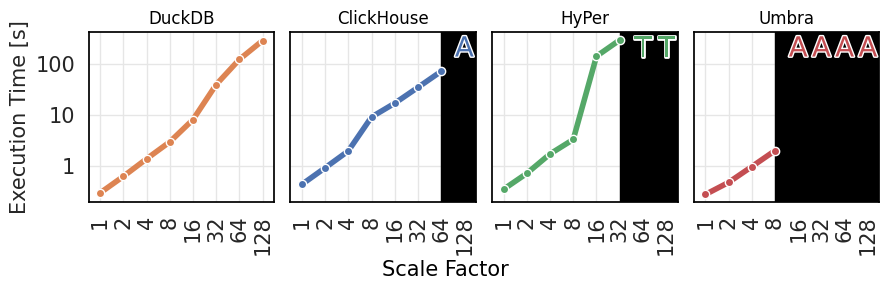

In [468]:
f = plt.figure(figsize=(9, 2.75))
modified_style = copy.copy(my_style)
modified_style['xtick.major.bottom'] = True
modified_style['axes.labelsize'] = 15
modified_style['ytick.labelsize'] = 15
# modified_style['ytick.major.left'] = False

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) as System,
                sf::VARCHAR AS "Scale Factor", grouping, wide, runtime AS "Execution Time [s]"
            FROM last_experiment_df
            WHERE runtime > 0
            ORDER BY System, sf
        """).fetchdf(),
        x='Scale Factor', y='Execution Time [s]', color='System'
    )
    .scale(y=so.Continuous(trans='log10').label(my_formatter).tick(minor=0))
    .facet(col='System', order={"col": ["DuckDB", "ClickHouse", "HyPer", "Umbra"]})
    .add(so.Line(linewidth=4, marker='o', edgecolor='w'))
    .theme(modified_style)
    .on(f)
    .plot()
)

fsize = 20

txt = f.axes[1].text(7, 200, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[0], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

rect = patches.Rectangle((6, 0.000001), 5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[1].add_patch(rect)

txt = f.axes[2].text(6, 200, "T", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[2], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[2].text(7, 200, "T", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[2], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

rect = patches.Rectangle((5, 0.000001), 5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[2].add_patch(rect)

txt = f.axes[3].text(4, 200, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[3].text(5, 200, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[3].text(6, 200, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
txt = f.axes[3].text(7, 200, "A", horizontalalignment='center', verticalalignment='center', color=sns.color_palette('deep')[3], fontsize=fsize)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])


rect = patches.Rectangle((3, 0.000001), 5, 1000, linewidth=1, edgecolor='black', facecolor='black')
f.axes[3].add_patch(rect)

for i in range(4):
    f.axes[i].grid(True, 'both')

# f.axes[0].set_ylabel('')
# f.axes[8].set_ylabel('')

f.axes[0].set_xlabel('')
f.axes[1].set_xlabel('')
f.axes[2].set_xlabel('')
f.axes[3].set_xlabel('')
f.axes[0].set_xticklabels(f.axes[0].get_xticklabels(), rotation=90, fontsize=15)
f.axes[1].set_xticklabels(f.axes[1].get_xticklabels(), rotation=90, fontsize=15)
f.axes[2].set_xticklabels(f.axes[2].get_xticklabels(), rotation=90, fontsize=15)
f.axes[3].set_xticklabels(f.axes[3].get_xticklabels(), rotation=90, fontsize=15)
f.text(0.5, 0, 'Scale Factor', horizontalalignment='center', verticalalignment='center', fontsize=15)

legend = f.legends.pop(0)
# f.axes[0].legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=15)
f.tight_layout()

f.savefig(f"../figures/all.eps", bbox_inches='tight')
# plt.close(f)

In [299]:
con.execute("""
SELECT * FROM last_experiment_df ORDER BY sf, runtime
""").fetchdf()
# up to sf8: umbra, duckdb, hyper, clickhouse
# sf16: duckdb, clickhouse, hyper
# sf32-64: clickhouse, duckdb, hyper

,system,sf,grouping,wide,runtime
0,umbra,1,all,False,0.283651
1,duckdb,1,all,False,0.303723
2,hyper,1,all,False,0.358506
3,clickhouse,1,all,False,0.445404
4,umbra,2,all,False,0.487274
5,duckdb,2,all,False,0.638124
6,hyper,2,all,False,0.731408
7,clickhouse,2,all,False,0.938366
8,umbra,4,all,False,0.991536
9,duckdb,4,all,False,1.404262
